## 最初の 2 次元測位

2023.7.23  
MCS 部屋で 2 次元測位を実施  
4k-13kHz の 9 発で 200ms のインターバル  
データベースを 9 点から作成  
5 点のテスト点


In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from positioning.readwav import readwav
from positioning.sound_db import SoundDB

In [3]:
sns.set()

In [4]:
db = SoundDB("../data/reference_2d", interval=0.2, dim=2)

In [5]:
true_pos = pd.read_csv(
    "../data/pos2d_20230723/true_positions.csv", skipinitialspace=True, index_col=0
)

In [6]:
true_pos.head()

,x,y
test1,0.008,0.597
test2,-0.002,1.092
test3,-0.038,1.522
test4,0.456,1.034
test5,-0.594,0.845


In [7]:
est_poses = []
errors = []
for i in range(5):
    test_signal = readwav(f"../data/pos2d_20230723/test0{i+1}.wav")
    err = []
    pos = []
    for j in range(100):
        est_pos = np.ravel(db.positioning(test_signal[j * 96000 : (j + 2) * 96000]))
        pos.append(est_pos)
        err.append(np.linalg.norm(est_pos - true_pos.iloc[i]))
    est_poses.append(pos)
    errors.append(err)

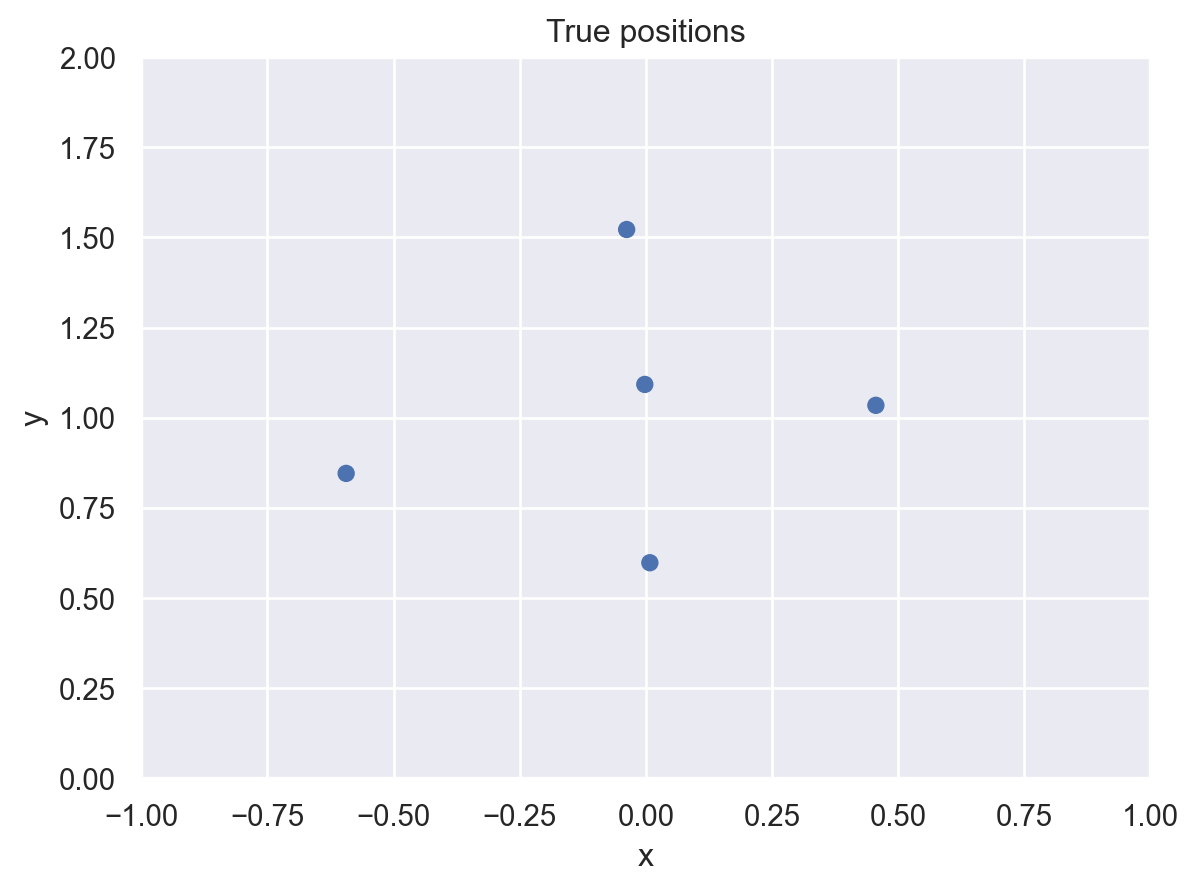

In [8]:
(
    so.Plot(true_pos, x="x", y="y")
    .add(so.Dot())
    .limit(x=(-1, 1), y=(0, 2))
    .label(title="True positions")
)

In [9]:
df_est = pd.DataFrame()
for i in range(5):
    df_est_pos = pd.DataFrame(est_poses[i], columns=["x", "y"])
    df_est_pos["error"] = errors[i]
    df_est_pos["test_position"] = f"test{i+1}"
    df_est = pd.concat([df_est, df_est_pos])

In [10]:
df_est.head()

,x,y,error,test_position
0,0.015003,0.859520,0.262613,test1
1,0.014989,0.858745,0.261838,test1
2,0.014994,0.859017,0.262111,test1
3,0.014994,0.858984,0.262078,test1
4,0.014997,0.859205,0.262298,test1


In [11]:
df_est.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 99
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              500 non-null    float64
 1   y              500 non-null    float64
 2   error          500 non-null    float64
 3   test_position  500 non-null    object 
dtypes: float64(3), object(1)
memory usage: 19.5+ KB


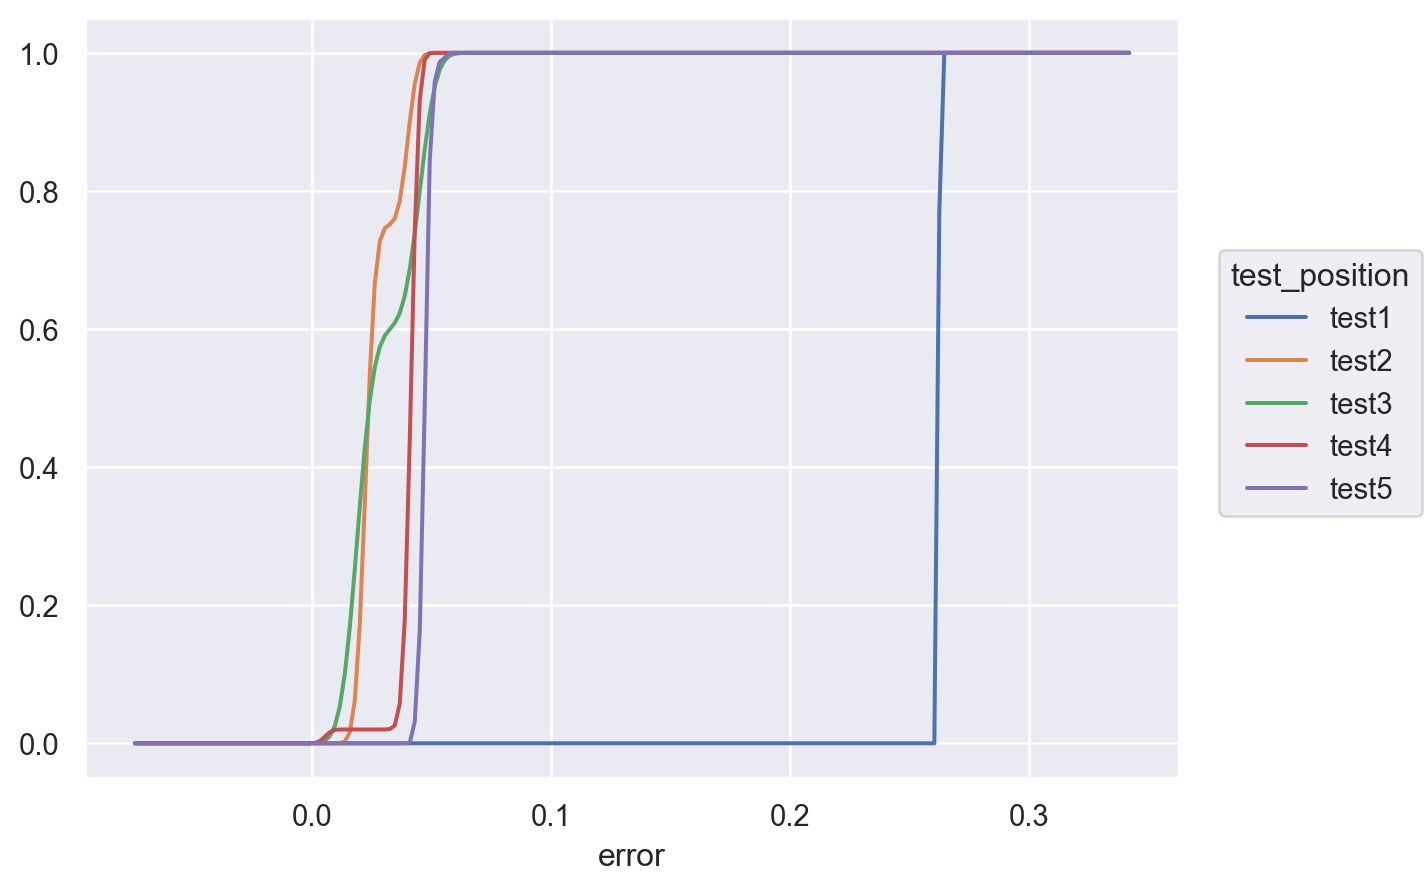

In [12]:
(
    so.Plot(df_est, x="error", color="test_position")
    .add(so.Lines(), so.KDE(cumulative=True, common_norm=False))
    .limit(x=(0, None))
)

In [13]:
df_positions = df_est[["x", "y", "test_position"]]
df_positions.loc[:, "true_or_test"] = "test"
true_pos["test_position"] = true_pos.index
true_pos["true_or_test"] = "true"
df_positions = pd.concat([df_positions, true_pos])
df_positions.reset_index(drop=True, inplace=True)
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              505 non-null    float64
 1   y              505 non-null    float64
 2   test_position  505 non-null    object 
 3   true_or_test   505 non-null    object 
dtypes: float64(2), object(2)
memory usage: 15.9+ KB


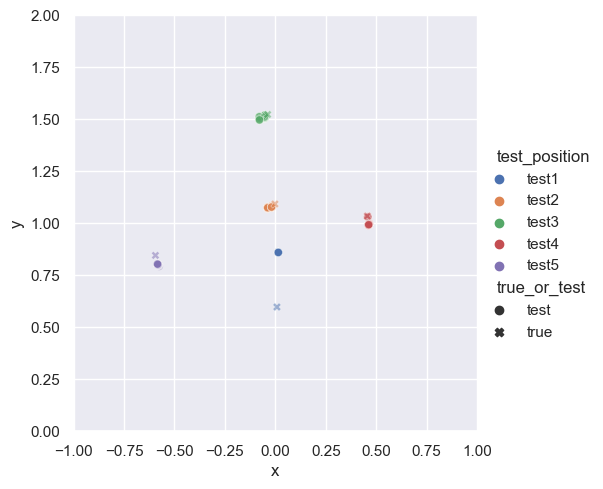

In [14]:
g = sns.relplot(
    data=df_positions,
    x="x",
    y="y",
    hue="test_position",
    style="true_or_test",
    alpha=0.5,
)
g.set(xlim=(-1, 1), ylim=(0, 2))

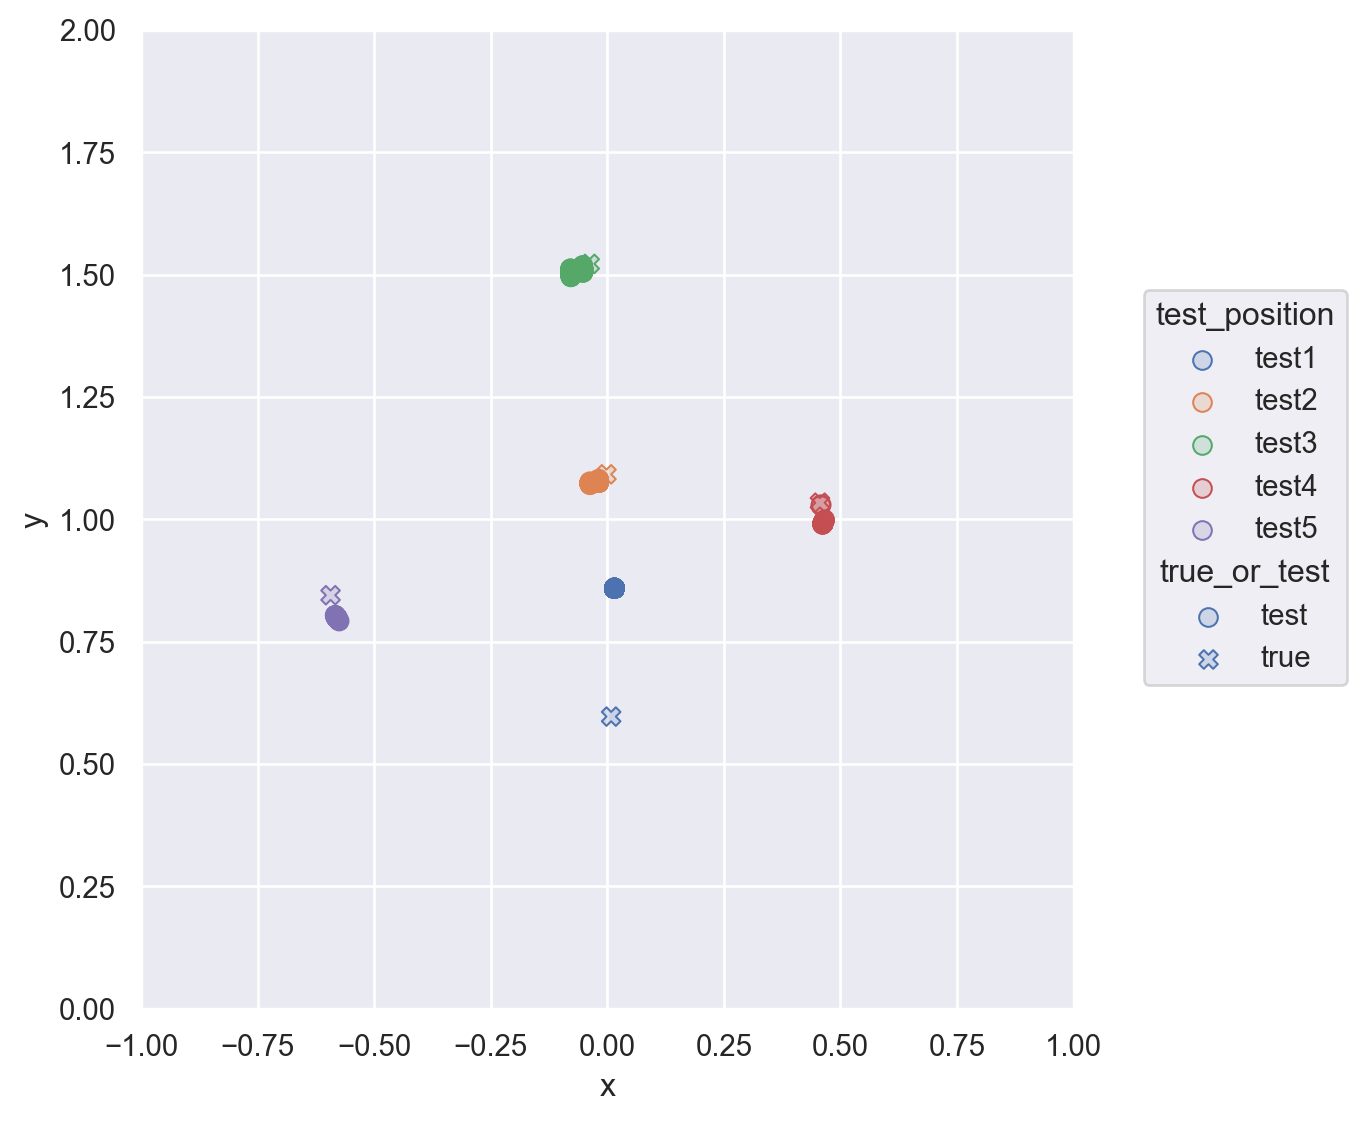

In [28]:
(
    so.Plot(df_positions, x="x", y="y", color="test_position", marker="true_or_test")
    .add(so.Dots(pointsize=7))
    .limit(x=(-1, 1), y=(0, 2))
    .layout(size=(6, 6))
)